                                                text  label
0  I rented I AM CURIOUS-YELLOW from my video sto...      0
1  "I Am Curious: Yellow" is a risible and preten...      0
2  If only to avoid making this type of film in t...      0
3  This film was probably inspired by Godard's Ma...      0
4  Oh, brother...after hearing about this ridicul...      0

 text     0
label    0
dtype: int64

 text     0
label    0
dtype: int64

Class distribution:
label
0    12500
1    12500
Name: count, dtype: int64


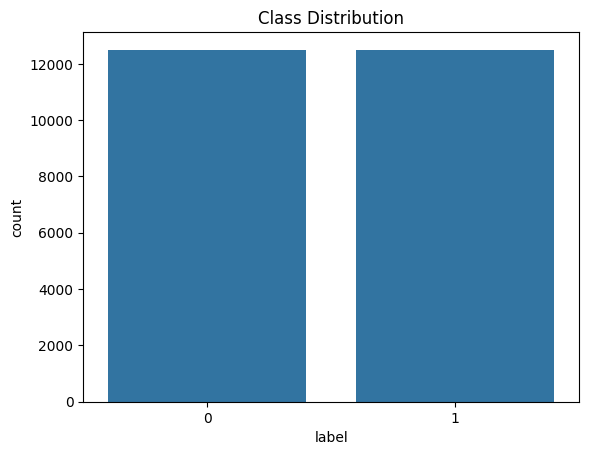


Class distribution:
label
0    12500
1    12500
Name: count, dtype: int64


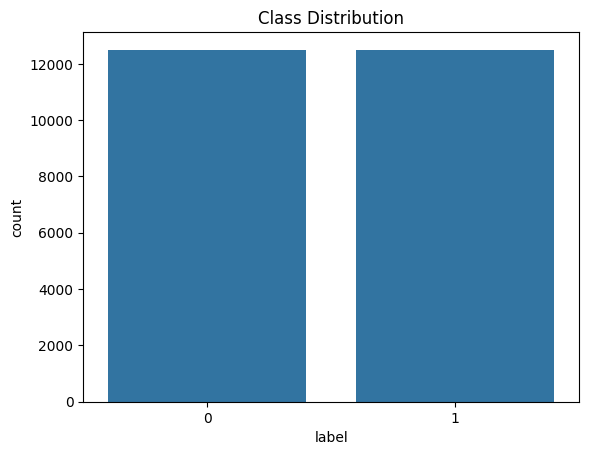

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from datasets import load_dataset  # Use `datasets` library to load IMDb dataset
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load the IMDb dataset (this will download it if it's not already available)
# The 'datasets' library version has a 'train' and 'test' split
dataset = load_dataset("imdb")

df_train = pd.DataFrame(dataset['train'])
df_test = pd.DataFrame(dataset['test'])

# Inspect data format (the dataset should have 'text' and 'label' columns)
print(df_train.head())

print('\n', df_train.isna().sum())
print('\n', df_test.isna().sum())

# Check class imbalance (number of positive vs negative reviews)
print("\nClass distribution:")
print(df_train['label'].value_counts())

# Visualize class distribution
sns.countplot(x='label', data=df_test)
plt.title('Class Distribution')
plt.show()

# Check class imbalance (number of positive vs negative reviews)
print("\nClass distribution:")
print(df_test['label'].value_counts())

# Visualize class distribution
sns.countplot(x='label', data=df_train)
plt.title('Class Distribution')
plt.show()


Training Set Statistics:
mean_length: 1325.07
median_length: 979.00
std_length: 1003.13
mean_words: 233.79
median_words: 174.00

Test Set Statistics:
mean_length: 1293.79
median_length: 962.00
std_length: 975.91
mean_words: 228.53
median_words: 172.00

Shortest Review (Train):
This movie is terrible but it has some good effects.

Longest Review (Train):
Match 1: Tag Team Table Match Bubba Ray and Spike Dudley vs Eddie Guerrero and Chris Benoit Bubba Ray and Spike Dudley started things off with a Tag Team Table Match against Eddie Guerrero and Chris Benoit. According to the rules of the match, both opponents have to go through tables in order to get the win. Benoit and Guerrero heated up early on by taking turns hammering first Spike and then Bubba Ray. A German suplex by Benoit to Bubba took the wind out of the Dudley brother. Spike tried to he...


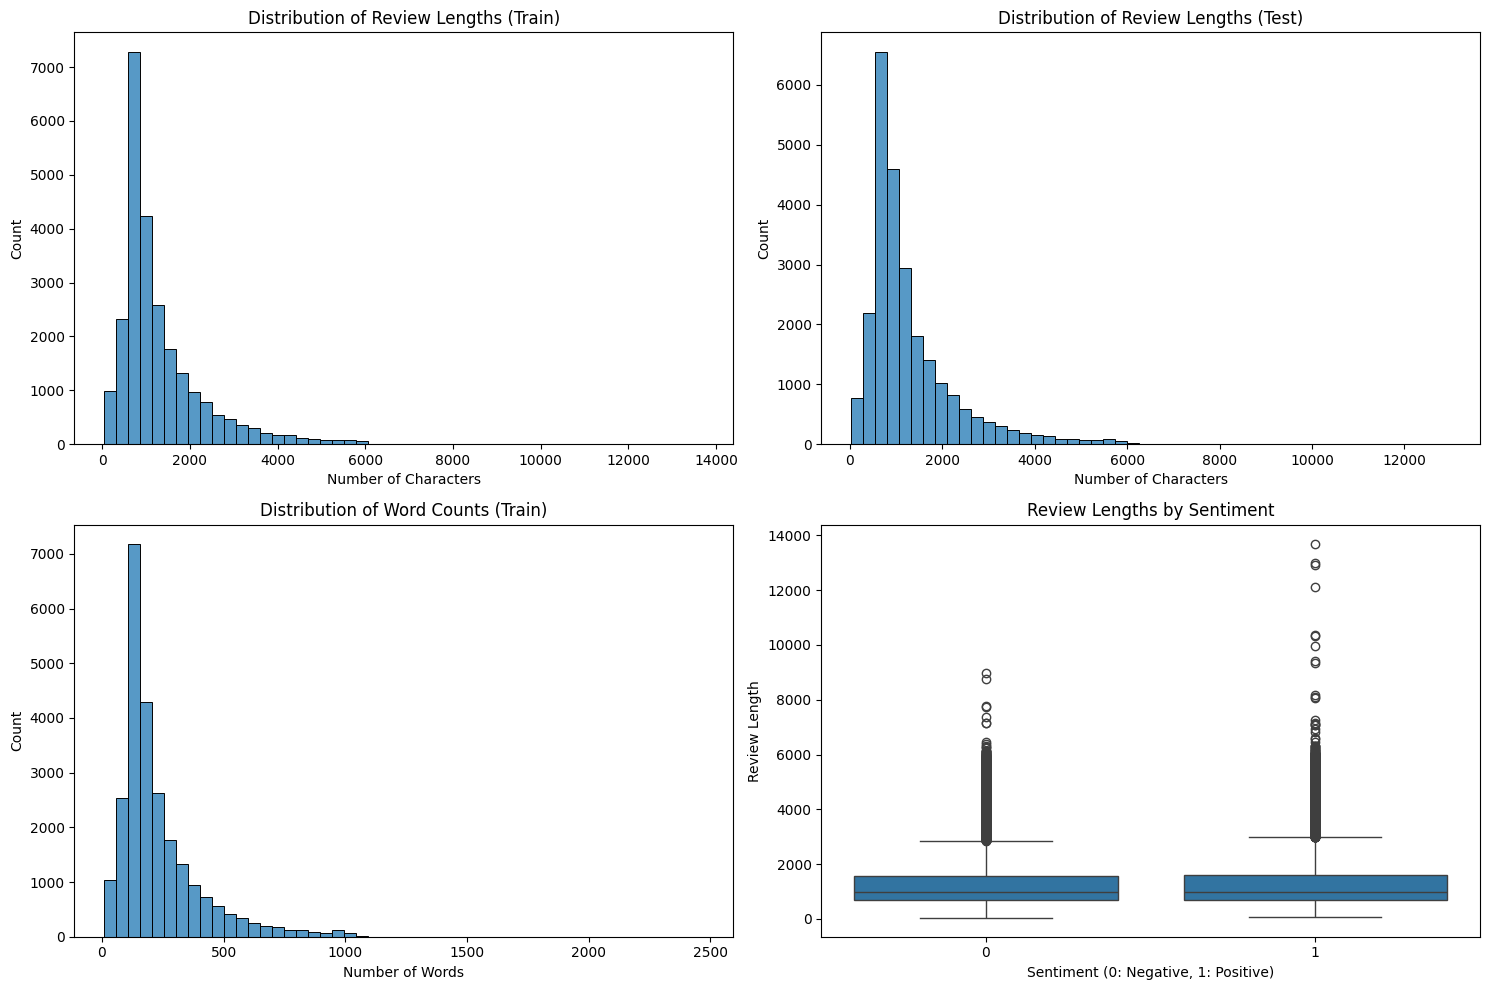

In [6]:
def analyze_review_lengths(train_df: pd.DataFrame, test_df: pd.DataFrame, text_column: str = 'text') -> None:
    """
    Analyze and visualize review lengths in IMDB dataset for both train and test sets.
    
    Parameters:
    -----------
    train_df : pd.DataFrame
        Training set DataFrame
    test_df : pd.DataFrame
        Test set DataFrame
    text_column : str, default='text'
        Name of the column containing review text
    """
    # Calculate lengths for both sets
    train_df['review_length'] = train_df[text_column].str.len()
    train_df['word_count'] = train_df[text_column].str.split().str.len()
    
    test_df['review_length'] = test_df[text_column].str.len()
    test_df['word_count'] = test_df[text_column].str.split().str.len()
    
    # Calculate summary statistics
    train_stats = {
        'mean_length': train_df['review_length'].mean(),
        'median_length': train_df['review_length'].median(),
        'std_length': train_df['review_length'].std(),
        'mean_words': train_df['word_count'].mean(),
        'median_words': train_df['word_count'].median()
    }
    
    test_stats = {
        'mean_length': test_df['review_length'].mean(),
        'median_length': test_df['review_length'].median(),
        'std_length': test_df['review_length'].std(),
        'mean_words': test_df['word_count'].mean(),
        'median_words': test_df['word_count'].median()
    }
    
    # Print statistics
    print("Training Set Statistics:")
    for metric, value in train_stats.items():
        print(f"{metric}: {value:.2f}")
        
    print("\nTest Set Statistics:")
    for metric, value in test_stats.items():
        print(f"{metric}: {value:.2f}")
    
    # Print some examples
    print("\nShortest Review (Train):")
    print(train_df.loc[train_df['review_length'].idxmin()][text_column])
    
    print("\nLongest Review (Train):")
    print(train_df.loc[train_df['review_length'].idxmax()][text_column][:500] + "...")
    
    # Visualizations
    plt.figure(figsize=(15, 10))
    
    # Review length distributions
    plt.subplot(2, 2, 1)
    sns.histplot(data=train_df, x='review_length', bins=50, label='Train')
    plt.title('Distribution of Review Lengths (Train)')
    plt.xlabel('Number of Characters')
    plt.ylabel('Count')
    
    plt.subplot(2, 2, 2)
    sns.histplot(data=test_df, x='review_length', bins=50, label='Test')
    plt.title('Distribution of Review Lengths (Test)')
    plt.xlabel('Number of Characters')
    plt.ylabel('Count')
    
    # Word count distributions
    plt.subplot(2, 2, 3)
    sns.histplot(data=train_df, x='word_count', bins=50)
    plt.title('Distribution of Word Counts (Train)')
    plt.xlabel('Number of Words')
    plt.ylabel('Count')
    
    # Box plot comparing lengths by sentiment
    plt.subplot(2, 2, 4)
    combined_df = pd.concat([
        train_df.assign(set='train'),
        test_df.assign(set='test')
    ])
    sns.boxplot(data=combined_df, x='label', y='review_length')
    plt.title('Review Lengths by Sentiment')
    plt.xlabel('Sentiment (0: Negative, 1: Positive)')
    plt.ylabel('Review Length')
    
    plt.tight_layout()
    plt.show()
    

# Run the analysis
analyze_review_lengths(df_train, df_test)


Test Accuracy: 0.89212

Confusion Matrix:
 [[11072  1428]
 [ 1269 11231]]


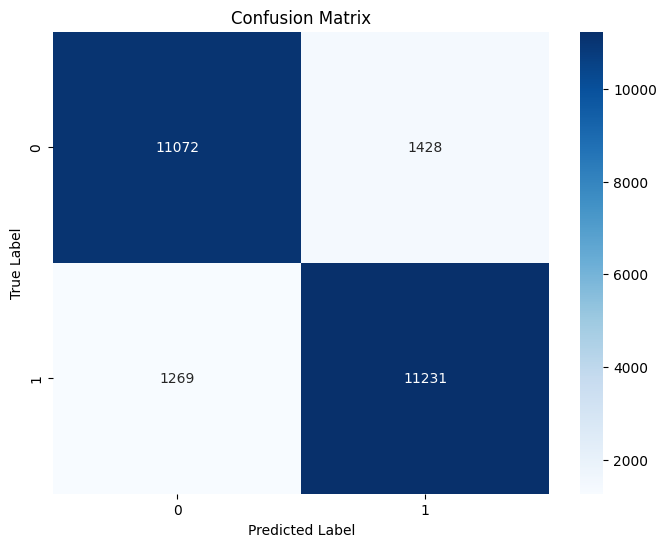


Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.89      0.89     12500
           1       0.89      0.90      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000



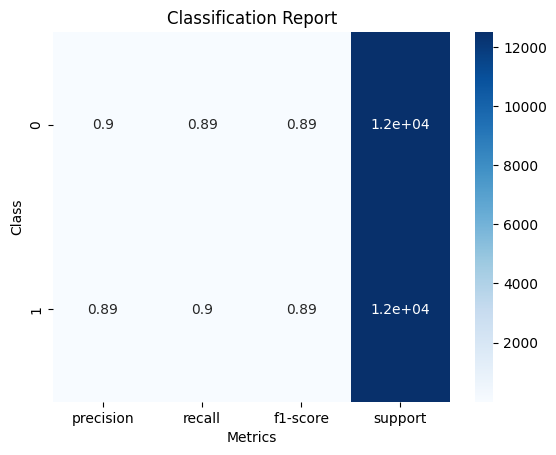

Fitting 3 folds for each of 6 candidates, totalling 18 fits

Best parameters: {'log_reg__C': 1, 'log_reg__solver': 'lbfgs'}

Best cross-validation score: 0.8767200028053918

Test Accuracy: 0.893

Confusion Matrix:
 [[11072  1428]
 [ 1247 11253]]


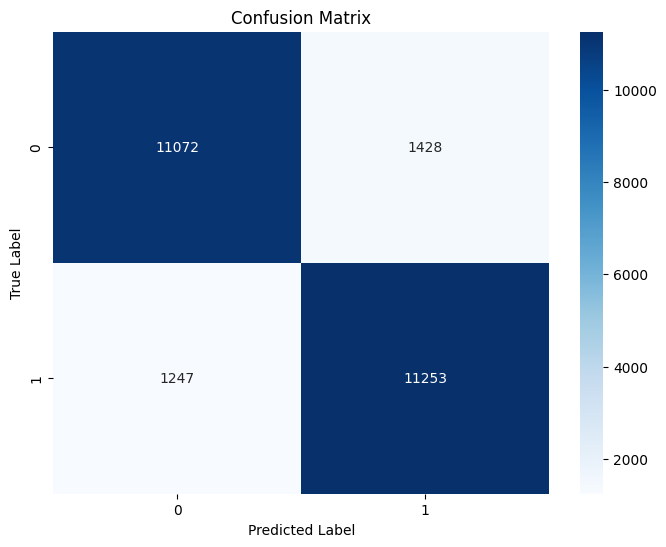


Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.89      0.89     12500
           1       0.89      0.90      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000



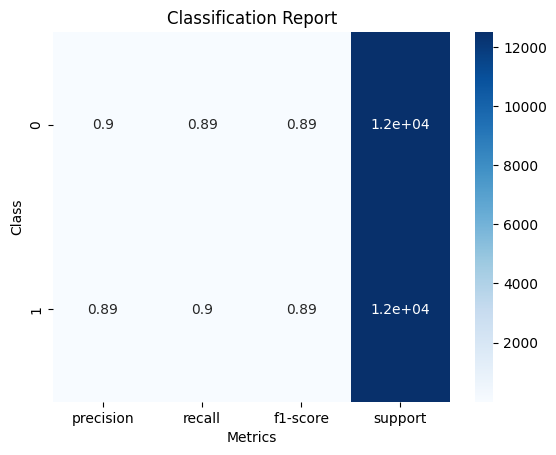

Sentence: This movie was absolutely fantastic!
Predicted Sentiment: Positive

Sentence: I hated every moment of this film.
Predicted Sentiment: Negative

Sentence: The storyline was gripping and full of surprises.
Predicted Sentiment: Positive

Sentence: The acting was terrible and the plot was predictable.
Predicted Sentiment: Negative

Sentence: It was an average movie with a few good scenes.
Predicted Sentiment: Positive



In [7]:
# Split data into features and labels
X_train = df_train['text']
y_train = df_train['label']
X_test = df_test['text']
y_test = df_test['label']

# Define a pipeline with TF-IDF and logistic regression
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), max_features=7777)),  # Use bigrams and limit to top 7777 features
    ('log_reg', LogisticRegression(max_iter=30, solver='liblinear'))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Visualizing Confusion Matrix
def plot_confusion_matrix(cm):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Visualizing Classification Report
def plot_classification_report(report):
    report_data = []
    lines = report.split('\n')
    for line in lines[2:-3]:
        parts = line.split()
        if len(parts) >= 5:  # Ensure enough parts to create a row
            row = {'class': parts[0]}
            row.update(dict(zip(['precision', 'recall', 'f1-score', 'support'], parts[1:])))
            report_data.append(row)

    df = pd.DataFrame.from_records(report_data)
    sns.heatmap(df.iloc[:, 1:].astype(float), annot=True, cmap='Blues')
    plt.xlabel('Metrics')
    plt.ylabel('Class')
    plt.title('Classification Report')
    plt.show()

# Evaluation
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
plot_confusion_matrix(confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
plot_classification_report(classification_report(y_test, y_pred))

# Define the hyperparameter grid for tuning
param_grid = {
    'log_reg__C': [0.1, 1, 10],             # Regularization strength
    'log_reg__solver': ['liblinear', 'lbfgs']  # Solvers for logistic regression
}

# Set up GridSearchCV with 3-fold cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Display best parameters and cross-validation score
print("\nBest parameters:", grid_search.best_params_)
print("\nBest cross-validation score:", grid_search.best_score_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluation
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
plot_confusion_matrix(confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
plot_classification_report(classification_report(y_test, y_pred))


# Testing custom sentences
custom_sentences = [
    "This movie was absolutely fantastic!",
    "I hated every moment of this film.",
    "The storyline was gripping and full of surprises.",
    "The acting was terrible and the plot was predictable.",
    "It was an average movie with a few good scenes."
]

# Predict sentiment for custom sentences
custom_predictions = best_model.predict(custom_sentences)

# Output predictions
for sentence, prediction in zip(custom_sentences, custom_predictions):
    sentiment = "Positive" if prediction == 1 else "Negative"
    print(f"Sentence: {sentence}\nPredicted Sentiment: {sentiment}\n")

C:\Users\00har\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 84s 253ms/step - accuracy: 0.7027 - loss: 0.5527 - val_accuracy: 0.7970 - val_loss: 0.4647
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 76s 243ms/step - accuracy: 0.9015 - loss: 0.2586 - val_accuracy: 0.7430 - val_loss: 0.6542
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 74s 238ms/step - accuracy: 0.9449 - loss: 0.1617 - val_accuracy: 0.8598 - val_loss: 0.3863
782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step

Test Accuracy: 0.86864

Confusion Matrix:
 [[10806  1694]
 [ 1590 10910]]


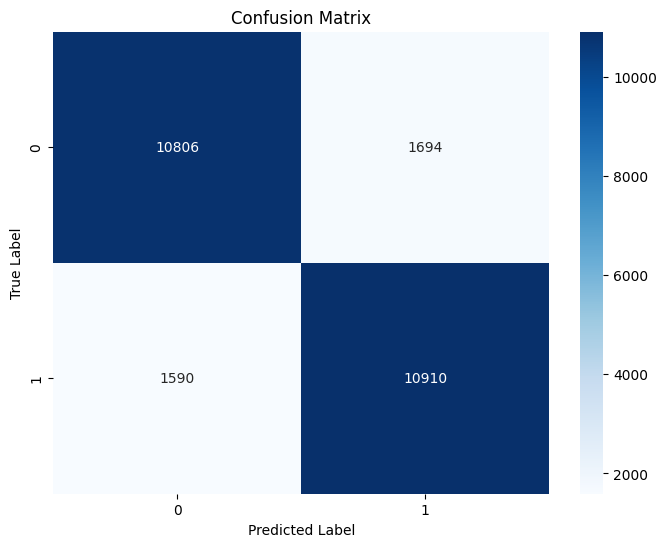


Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.86      0.87     12500
           1       0.87      0.87      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



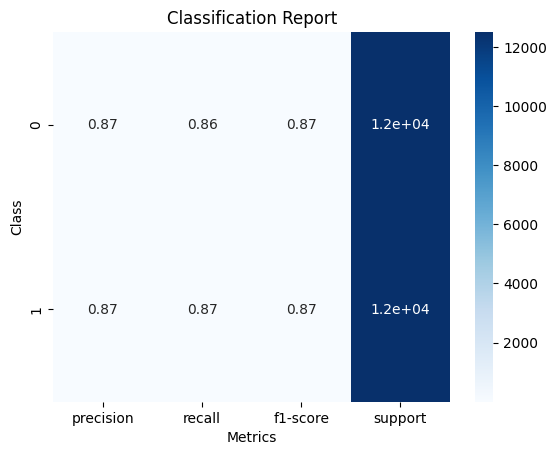

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Sentence: This movie was absolutely fantastic!
Predicted Sentiment: Positive

Sentence: I hated every moment of this film.
Predicted Sentiment: Negative

Sentence: The storyline was gripping and full of surprises.
Predicted Sentiment: Positive

Sentence: The acting was terrible and the plot was predictable.
Predicted Sentiment: Negative

Sentence: It was an average movie with a few good scenes.
Predicted Sentiment: Positive



In [8]:
# Preprocess text data with tokenization and padding
max_words = 7000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df_train['text'])

X_train = tokenizer.texts_to_sequences(df_train['text'])
X_test = tokenizer.texts_to_sequences(df_test['text'])

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

y_train = np.array(df_train['label'])
y_test = np.array(df_test['label'])

# Define a GRU model for sentiment analysis
model = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    GRU(64, return_sequences=True),
    Dropout(0.5),
    GRU(32),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=3, batch_size=64, validation_split=0.2, callbacks=[early_stop])

# Evaluate the model on the test set
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Convert predictions to a 1-dimensional array
y_pred = y_pred.flatten()

# Display results
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
plot_confusion_matrix(confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
plot_classification_report(classification_report(y_test, y_pred))

# Testing custom sentences
custom_sentences = [
    "This movie was absolutely fantastic!",
    "I hated every moment of this film.",
    "The storyline was gripping and full of surprises.",
    "The acting was terrible and the plot was predictable.",
    "It was an average movie with a few good scenes."
]

# Tokenize and pad custom sentences
custom_sequences = tokenizer.texts_to_sequences(custom_sentences)
custom_padded = pad_sequences(custom_sequences, maxlen=max_len)

# Predict sentiment for custom sentences
custom_predictions = model.predict(custom_padded)
custom_predictions = (custom_predictions > 0.5).astype("int32")

# Output predictions
for sentence, prediction in zip(custom_sentences, custom_predictions):
    sentiment = "Positive" if prediction == 1 else "Negative"
    print(f"Sentence: {sentence}\nPredicted Sentiment: {sentiment}\n")